In [1]:
import pandas as pd
import numpy as np

In [2]:
# Importing main data cell lines and drug response
cell_lines_pd = pd.read_csv ("OmicsExpressionProteinCodingGenesTPMLogp1.csv", index_col=0)
response_pd = pd.read_csv ("Repurposing_Public_24Q2_Extended_Primary_Data_Matrix.csv", index_col=0)

In [3]:
print(cell_lines_pd.shape)

(1673, 19193)


In [4]:
print(response_pd.shape)
print(response_pd.isnull().sum().sum())

(6790, 919)
2026962


In [5]:
#Transposing response drugs to rows to posteriously merge to lines dataset
response_transposed = response_pd.T

## Filtering both datasets to only have the common ones 

In [7]:
#Resetting indexes 
print(response_transposed.columns)  # See available column names
print(response_transposed.index[:5])  # See if cell lines are already the index

Index(['BRD:BRD-A00047421-001-01-7', 'BRD:BRD-A00055058-001-01-0',
       'BRD:BRD-A00077618-236-07-6', 'BRD:BRD-A00092689-236-04-9',
       'BRD:BRD-A00100033-001-08-9', 'BRD:BRD-A00147595-001-01-5',
       'BRD:BRD-A00218260-001-03-4', 'BRD:BRD-A00376169-001-01-6',
       'BRD:BRD-A00520476-001-07-4', 'BRD:BRD-A00546892-001-02-6',
       ...
       'BRD:BRD-M92352362-002-02-3', 'BRD:BRD-M92675308-003-07-1',
       'BRD:BRD-M93148412-001-02-6', 'BRD:BRD-M97302542-001-03-6',
       'BRD:BRD-M98279124-300-01-1', 'BRD:BRD-U08520523-000-01-0',
       'BRD:BRD-U25960968-000-01-9', 'BRD:BRD-U45393375-000-01-6',
       'BRD:BRD-U48018661-000-01-9', 'BRD:BRD-U51753822-000-01-1'],
      dtype='object', length=6790)
Index(['ACH-000001', 'ACH-000002', 'ACH-000004', 'ACH-000005', 'ACH-000006'], dtype='object')


In [8]:
print(cell_lines_pd.head(10))

            TSPAN6 (7105)  TNMD (64102)  DPM1 (8813)  SCYL3 (57147)  \
ACH-001113       4.331992      0.000000     7.364660       2.792855   
ACH-001289       4.567424      0.584963     7.106641       2.543496   
ACH-001339       3.150560      0.000000     7.379118       2.333424   
ACH-001979       4.240314      0.000000     5.681168       2.063503   
ACH-002438       4.032101      0.000000     6.674687       2.117695   
ACH-001538       5.085340      0.000000     7.154211       2.545968   
ACH-000242       6.729417      0.000000     6.537917       2.456806   
ACH-000708       4.272770      0.189034     7.023255       2.555816   
ACH-000327       3.337711      0.000000     5.927659       1.944858   
ACH-000233       0.056584      0.000000     6.094236       3.971773   

            C1orf112 (55732)  FGR (2268)  CFH (3075)  FUCA2 (2519)  \
ACH-001113          4.471187    0.028569    1.226509      3.044394   
ACH-001289          3.504620    0.000000    0.189034      3.813525   
ACH-0013

In [9]:
# Checking for common cell lines
common_cells = cell_lines_pd.index.intersection(response_transposed.index)
common_cells

Index(['ACH-001113', 'ACH-001289', 'ACH-001538', 'ACH-000242', 'ACH-000233',
       'ACH-000461', 'ACH-001794', 'ACH-002023', 'ACH-000528', 'ACH-001655',
       ...
       'ACH-000114', 'ACH-001578', 'ACH-000036', 'ACH-000973', 'ACH-001128',
       'ACH-000750', 'ACH-000285', 'ACH-001858', 'ACH-001997', 'ACH-000052'],
      dtype='object', length=901)

In [10]:
# Filtering both with common cell lines
genes_filtered    = cell_lines_pd.loc[common_cells]
response_filtered = response_transposed.loc[common_cells]

In [11]:
print(genes_filtered .shape)

(901, 19193)


In [12]:
print(response_filtered.shape)

(901, 6790)


### Data exploration 

In [14]:
# Checking for duplicate values 
print(genes_filtered.index.duplicated().sum())  

0


In [15]:
print(response_filtered.index.duplicated().sum())  

0


In [16]:
# Checking for empty values
print(genes_filtered.isnull().sum().sum())
print(response_filtered.isnull().sum().sum())

0
1967792


## Melting data to achieve long format 

In [18]:
# Melt the DataFrame
# We reset the index to turn 'cell_line' from an index into a column
efficacy_long = response_filtered.reset_index().melt(
    id_vars='index',         # Column to keep as is (our cell lines)
    var_name='drug',         # New column for what were the column headers (drugs)
    value_name='efficacy'    # New column for the values
)
efficacy_long.rename(columns={'index': 'cell_line'}, inplace=True)

In [19]:
print("Melted Efficacy Data (before dropping NaNs):")
print(efficacy_long)

Melted Efficacy Data (before dropping NaNs):
          cell_line                        drug  efficacy
0        ACH-001113  BRD:BRD-A00047421-001-01-7 -2.860765
1        ACH-001289  BRD:BRD-A00047421-001-01-7  0.163156
2        ACH-001538  BRD:BRD-A00047421-001-01-7 -2.698254
3        ACH-000242  BRD:BRD-A00047421-001-01-7 -0.333245
4        ACH-000233  BRD:BRD-A00047421-001-01-7 -3.231683
...             ...                         ...       ...
6117785  ACH-000750  BRD:BRD-U51753822-000-01-1 -0.190344
6117786  ACH-000285  BRD:BRD-U51753822-000-01-1       NaN
6117787  ACH-001858  BRD:BRD-U51753822-000-01-1       NaN
6117788  ACH-001997  BRD:BRD-U51753822-000-01-1       NaN
6117789  ACH-000052  BRD:BRD-U51753822-000-01-1  0.035084

[6117790 rows x 3 columns]


In [20]:
# Drop the rows where efficacy was not measured (the NaNs)
efficacy_final = efficacy_long.dropna(subset=['efficacy'])

In [21]:
print("\nFinal Tidy Efficacy Data (NaNs removed):")
print(efficacy_final)


Final Tidy Efficacy Data (NaNs removed):
          cell_line                        drug  efficacy
0        ACH-001113  BRD:BRD-A00047421-001-01-7 -2.860765
1        ACH-001289  BRD:BRD-A00047421-001-01-7  0.163156
2        ACH-001538  BRD:BRD-A00047421-001-01-7 -2.698254
3        ACH-000242  BRD:BRD-A00047421-001-01-7 -0.333245
4        ACH-000233  BRD:BRD-A00047421-001-01-7 -3.231683
...             ...                         ...       ...
6117780  ACH-000114  BRD:BRD-U51753822-000-01-1  0.652678
6117783  ACH-000973  BRD:BRD-U51753822-000-01-1 -0.618262
6117784  ACH-001128  BRD:BRD-U51753822-000-01-1 -0.190665
6117785  ACH-000750  BRD:BRD-U51753822-000-01-1 -0.190344
6117789  ACH-000052  BRD:BRD-U51753822-000-01-1  0.035084

[4149998 rows x 3 columns]


In [44]:
genes_filtered_reset = genes_filtered.reset_index()  # index → column
genes_filtered_reset = genes_filtered_reset.rename(columns={'index': 'cell_line'})

### Reducing dimensionality of genes data (PCA)

In [47]:
genes_df = genes_filtered_reset.set_index('cell_line')

In [49]:
# Scalling data before PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
genes_scaled = scaler.fit_transform(genes_df)

In [50]:
# Back to dataframe 

genes_scaled_df = pd.DataFrame(
    genes_scaled,
    index=genes_df.index,             # re-attach cell line names
    columns=genes_df.columns          # keep gene names
)

In [51]:
# Keeping components that together explain 95% of the variation
pca = PCA(n_components=0.95)  
genes_pca = pca.fit_transform(genes_scaled_df)

In [52]:
# Back to DF
genes_pca_df = pd.DataFrame(
    genes_pca,
    index=genes_scaled_df.index,                    # cell line names
    columns=[f'PC{i+1}' for i in range(genes_pca.shape[1])]  # PC1, PC2, ..., PCn
)

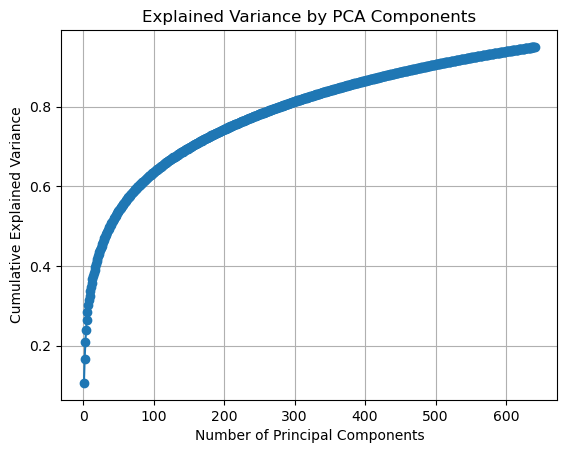

In [53]:
# PCA variance explanation 
import matplotlib.pyplot as plt

explained_var = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_var) + 1), explained_var.cumsum(), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

In [56]:
# Merging PCA component to efficacy data 
model_df = pd.merge(
    efficacy_final, 
    genes_pca_df,     
    on='cell_line'
)

In [57]:
print("\nSuccessfully created the final modeling DataFrame:")
print(model_df.head())
print(f"Shape of the final DataFrame: {model_df.shape}")


Successfully created the final modeling DataFrame:
    cell_line                        drug  efficacy        PC1        PC2  \
0  ACH-001113  BRD:BRD-A00047421-001-01-7 -2.860765  23.732197  14.643969   
1  ACH-001289  BRD:BRD-A00047421-001-01-7  0.163156  39.547212  -4.682764   
2  ACH-001538  BRD:BRD-A00047421-001-01-7 -2.698254 -37.891734  22.109658   
3  ACH-000242  BRD:BRD-A00047421-001-01-7 -0.333245  -3.483760   6.597288   
4  ACH-000233  BRD:BRD-A00047421-001-01-7 -3.231683   9.204201 -29.477180   

         PC3        PC4        PC5        PC6        PC7  ...     PC632  \
0   2.034826 -13.433906  13.635756 -36.908951   2.770349  ...  0.803681   
1 -38.368234 -39.979698  33.165196 -31.837503  26.013096  ...  0.148893   
2  10.967585  10.973287  30.161686 -49.958640   8.577335  ... -1.926645   
3  36.734168   5.106804  18.967784   4.133437  -6.435150  ... -0.741849   
4   6.017780  33.043529 -32.859092 -20.301295   6.804604  ...  0.364864   

      PC633     PC634     PC635   

## 1_Regression Model 

In [59]:
# Setting target drug for the model , BRD:BRD-A00047421-001-01-7, for this case
target_drug = "BRD:BRD-A00047421-001-01-7"

In [60]:
# subseting for target drug 
drug_df = model_df[model_df['drug'] == target_drug].copy()

In [61]:
# Spliting X and y , features and target 
X = drug_df.drop(columns=['cell_line', 'drug', 'efficacy'])

# Targe, drug efficacy for this drug
y = drug_df['efficacy']

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [63]:
# Baseline linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [64]:
y_pred = lr.predict(X_test)

In [66]:
# Evaluation 
# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Linear Regression R²: {r2:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")

Linear Regression R²: -49.8152
Linear Regression RMSE: 10.3674


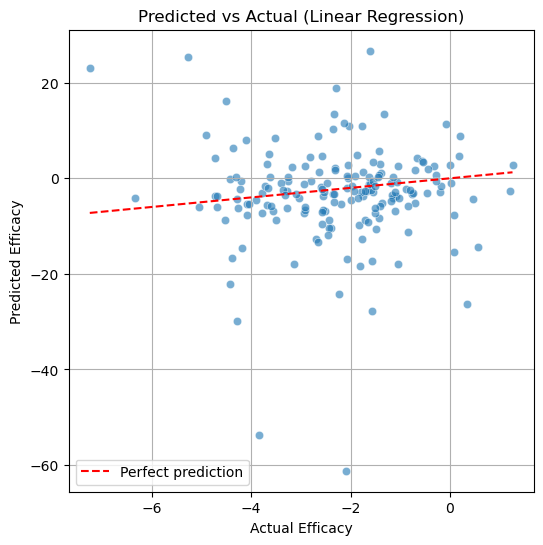

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect prediction')
plt.xlabel("Actual Efficacy")
plt.ylabel("Predicted Efficacy")
plt.title("Predicted vs Actual (Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()

## 2_Decission Tree Regressor Model

In [71]:
from sklearn.tree import DecisionTreeRegressor

# Initialize with default settings
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [72]:
# Predict
y_pred_tree = tree.predict(X_test)

In [75]:
# Evaluation 
r2_tree = r2_score(y_test, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))

print(f"Decision Tree R²: {r2_tree:.4f}")
print(f"Decision Tree RMSE: {rmse_tree:.4f}")

Decision Tree R²: -0.7674
Decision Tree RMSE: 1.9335


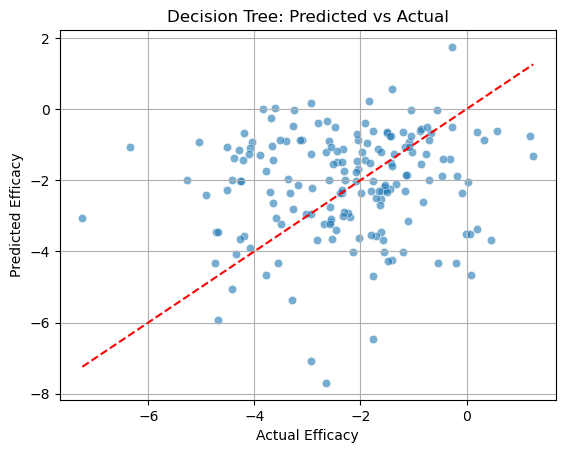

In [77]:
# Predicted vs Actual
sns.scatterplot(x=y_test, y=y_pred_tree, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Efficacy")
plt.ylabel("Predicted Efficacy")
plt.title("Decision Tree: Predicted vs Actual")
plt.grid(True)
plt.show()

## 3_XGBoost Regressor Model 

In [203]:
from xgboost import XGBRegressor

# Initialize model 
xgb = XGBRegressor(
    max_depth=6,
    n_estimators=500,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    reg_alpha=1,
    random_state=42
)

In [205]:
# Train
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

XGBoost R²: -0.0350
XGBoost RMSE: 1.4796


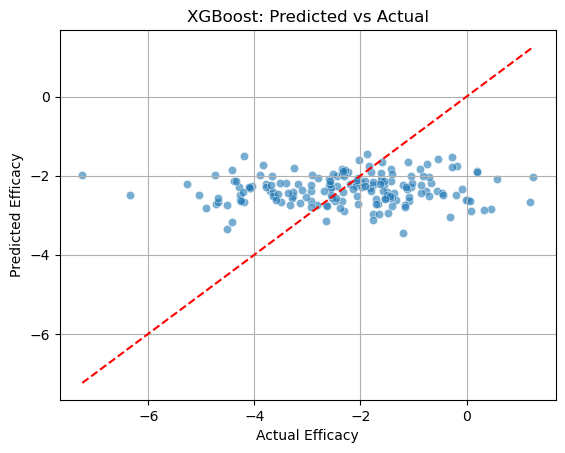

In [206]:
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost R²: {r2_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Efficacy")
plt.ylabel("Predicted Efficacy")
plt.title("XGBoost: Predicted vs Actual")
plt.grid(True)
plt.show()

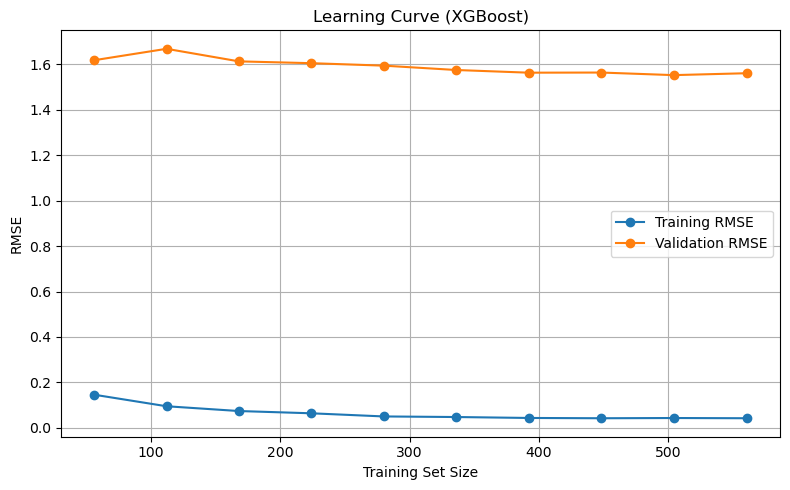

In [207]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 increments from 10% to 100%
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Convert to positive RMSE values
train_rmse = -np.mean(train_scores, axis=1)
test_rmse = -np.mean(test_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse, 'o-', label='Training RMSE')
plt.plot(train_sizes, test_rmse, 'o-', label='Validation RMSE')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()